In [1]:
import pandas as pd
import geopandas as gpd
import time
from datetime import datetime
from shapely.geometry import Point, LineString

def load_gps_data_seattle(filename, crs, to_crs):
    print('loading Seattle GPS Trajectory')
    gps_track = pd.read_csv(filename,
                            header=None,
                            names=['Data(UTC)', 'Time(UTC)', 'lat', 'lon'],
                            skiprows=[0],
                            delim_whitespace=True)
    # string to datetime
    gps_track['datetime'] = gps_track.apply(
        lambda row: datetime.strptime(row['Data(UTC)'] + ' ' + row['Time(UTC)'], '%d-%b-%Y %H:%M:%S'), axis=1)
    gps_track.drop(['Data(UTC)', 'Time(UTC)'], axis=1, inplace=True)
    # datetime to unix time
    gps_track['timestamp'] = gps_track.apply(lambda row: time.mktime(row['datetime'].timetuple()), axis=1)
    gps_track['geometry'] = gps_track.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
    gps_track = gpd.GeoDataFrame(gps_track, crs=crs)
    gps_track.to_crs(to_crs, inplace=True)
    return gps_track

In [2]:
crs = {'init': 'epsg:4326'}
to_crs = {'init': 'epsg:3395'}
trip_file = './data/Seattle/gps_data.txt'
trip = load_gps_data_seattle(trip_file, crs, to_crs)

loading Seattle GPS Trajectory


In [3]:
trip.head()

,lat,lon,datetime,timestamp,geometry
0,47.667483,-122.107083,2009-01-17 20:27:37,1.232195e+09,POINT (-13592898.33520784 6020110.32713188)
1,47.667500,-122.107067,2009-01-17 20:27:38,1.232195e+09,POINT (-13592896.48730429 6020113.074315307)
2,47.667500,-122.107067,2009-01-17 20:27:39,1.232195e+09,POINT (-13592896.48730429 6020113.074315307)
3,47.667517,-122.107033,2009-01-17 20:27:40,1.232195e+09,POINT (-13592892.7692333 6020115.821499617)
4,47.667533,-122.106983,2009-01-17 20:27:41,1.232195e+09,POINT (-13592887.20325876 6020118.56703683)


In [4]:
def compute_time_gap(traj):
    # compute time gap between consecutive records
    temp = pd.DataFrame()
    temp['t'] = traj['timestamp']
    temp['tt'] = traj['timestamp'].shift(1)
    time_gaps = temp['t'] - temp['tt']
    time_gaps.fillna(0, inplace=True)
    return time_gaps

trip['time_gap'] = compute_time_gap(trip)

In [5]:
trip.head()

,lat,lon,datetime,timestamp,geometry,time_gap
0,47.667483,-122.107083,2009-01-17 20:27:37,1.232195e+09,POINT (-13592898.33520784 6020110.32713188),0.0
1,47.667500,-122.107067,2009-01-17 20:27:38,1.232195e+09,POINT (-13592896.48730429 6020113.074315307),1.0
2,47.667500,-122.107067,2009-01-17 20:27:39,1.232195e+09,POINT (-13592896.48730429 6020113.074315307),1.0
3,47.667517,-122.107033,2009-01-17 20:27:40,1.232195e+09,POINT (-13592892.7692333 6020115.821499617),1.0
4,47.667533,-122.106983,2009-01-17 20:27:41,1.232195e+09,POINT (-13592887.20325876 6020118.56703683),1.0


In [8]:
trip[trip.time_gap > 1]

,lat,lon,datetime,timestamp,geometry,time_gap
2660,47.589833,-122.251450,2009-01-17 21:12:27,1.232198e+09,POINT (-13608969.16273935 6007323.324260412),31.0
2772,47.590533,-122.303583,2009-01-17 21:14:53,1.232198e+09,POINT (-13614772.61514872 6007438.511346154),35.0
2928,47.613183,-122.330183,2009-01-17 21:17:41,1.232198e+09,POINT (-13617733.71360382 6011166.473198468),13.0
6829,47.641450,-122.321817,2009-01-17 22:22:47,1.232202e+09,POINT (-13616802.34795215 6015821.161850452),6.0


In [9]:
# Feature based map matching
# find key gps points by Dauglas-Peucker algorithm
def find_key_points(trip, tolerance):
    # simplification
    line = LineString(list(trip['geometry']))
    simplified_line = line.simplify(tolerance, preserve_topology=False)
    print(len(line.coords), len(simplified_line.coords))
    point_list = list(line.coords)
    simplified_point_list = list(simplified_line.coords)
    key_point_idx = [point_list.index(point) for point in simplified_point_list]
    return key_point_idx

In [12]:
tolerance = 0.99
segment = trip[:2660]
key_point_idx = find_key_points(segment, tolerance)


(2660, 1014)


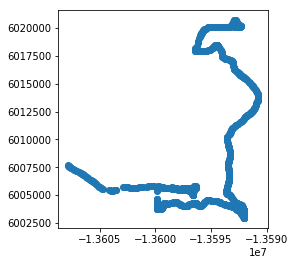

In [13]:
%matplotlib inline
trip.iloc[key_point_idx].plot()

In [7]:
from shapely import wkt
import networkx as nx

def remove_edges_with_single_point(road):
    index_list = []
    for row_index, row in road.iterrows():
        if row['geometry'].coords[0] == row['geometry'].coords[-1] and 2 == len(row['geometry'].coords):
            index_list.append(row_index)
    road.drop(index_list, inplace=True)
    # road.reset_index()
    print('Removed edges with single point: ')
    print index_list
    # column_names = ['Edge_ID', 'from', 'to', 'two_way', 'max speed', 'vertex_count', 'geometry']
    # return pd.DataFrame(road.values, columns=column_names )


def get_nodes_id_coordinate_dict(road):
    nodes_dict = {}  # key: node_id, value: a list (the gps coordinate of the node, edge_ids....)
    for row_index, row in road.iterrows():
        start_point = row['geometry'].coords[0]
        start_node_id = row['from']
        if nodes_dict.has_key(start_node_id):
            if nodes_dict[start_node_id][0] != start_point:
                print(start_node_id, nodes_dict[start_node_id], (start_point, row_index))
            nodes_dict[start_node_id].append(row_index)
        else:
            nodes_dict[start_node_id] = [start_point, row_index]
        end_point = row['geometry'].coords[-1]
        end_node_id = row['to']
        if nodes_dict.has_key(end_node_id):
            if nodes_dict[end_node_id][0] != end_point:
                print(end_node_id, nodes_dict[end_node_id], (end_point, row_index))
            nodes_dict[end_node_id].append(row_index)
        else:
            nodes_dict[end_node_id] = [end_point, row_index]
    print('There are %d nodes in the road network!' % len(nodes_dict))
    return nodes_dict


def get_nodes_coordinate_id_dict(nodes_dict):
    point_id_dict = {}  # key: a gps coordinate, value: a tuple (edge_id, node_id)
    for node_id, value in nodes_dict.items():
        point = value[0]
        edge_index_list = value[1:]
        if point_id_dict.has_key(point):
            point_id_dict[point].append((edge_index_list, node_id))
        else:
            point_id_dict[point] = [(edge_index_list, node_id)]
    return point_id_dict


def get_nodes_with_different_ids(road):
    nodes_dict = get_nodes_id_coordinate_dict(road)
    point_id_dict = get_nodes_coordinate_id_dict(nodes_dict)
    nodes_with_different_ids = []
    # id_dict = {}
    for point, value in point_id_dict.items():
        if len(value) > 1:
            nodes_with_different_ids.append(value)
            # for i in range(len(value)):
            #    id_list = []
            #    for j in range(len(value)):
            #        if j != i:
            #            id_list.append(value[j])
            #    id_dict[value[i][1]] = id_list
    return nodes_with_different_ids  # , id_dict


def combine_same_nodes(road, nodes_with_different_ids):
    road_values = road.values
    for i in range(len(nodes_with_different_ids)):
        final_node_id = nodes_with_different_ids[i][0][1]
        ind_list = []
        node_id_ind = 0
        for j in range(len(nodes_with_different_ids[i])):
            edge_id_list = nodes_with_different_ids[i][j][0]
            node_id = nodes_with_different_ids[i][j][1]
            if len(edge_id_list) < 2:
                ind_list.append(j)
            else:
                if len(edge_id_list) > len(nodes_with_different_ids[i][0][0]):
                    final_node_id = node_id
                    node_id_ind = j
        print i, final_node_id, ind_list
        # update node ids
        for k in ind_list:
            if k != node_id_ind:
                node_id = nodes_with_different_ids[i][k][1]
                edge_id_list = nodes_with_different_ids[i][k][0]
                for edge_id in edge_id_list:
                    from_node_id = road.iloc[edge_id]['from']
                    to_node_id = road.iloc[edge_id]['to']
                    print edge_id, from_node_id, to_node_id, node_id
                    if from_node_id == node_id:
                        road_values[edge_id][1] = final_node_id
                        print('Change %d to %d in edge %d ' % (node_id, final_node_id, edge_id))
                    elif to_node_id == node_id:
                        road_values[edge_id][2] = final_node_id
                        print('Change %d to %d in edge %d ' % (node_id, final_node_id, edge_id))
                    else:
                        print('Node %d is not in edge %d.' % (node_id, edge_id))
    column_names = ['Edge_ID', 'from', 'to', 'two_way', 'max speed', 'vertex_count', 'geometry']
    return pd.DataFrame(road_values, columns=column_names)

def calculate_bearing(pt1, pt2):
    """
    calculate bearing of the segment (pt1, pt2)
    :param pt1: a shapely.geometry.Point, a utm coordinate
    :param pt2: a shapely.geometry.Point, a utm coordinate
    :return: the bearing degree, float range in [0, 360)
    """
    import math
    x_diff = pt2.x - pt1.x
    y_diff = pt2.y - pt1.y
    bearing = math.degrees(math.atan2(y_diff, x_diff))
    if bearing < 0:
        return bearing + 360
    else:
        return bearing
    
    
def load_road_network_seattle(filename, crs, to_crs):
    """
    prepare Seattle road network data
    :param filename:
    :param crs:
    :param to_crs
    :return:
    """
    print('loading Seattle Road Network ...')
    # column_names = ['Edge_ID', 'From_Node_ID', 'To_Node_ID', 'Two_Way', 'Speed(m/s)', 'Vertex_Count', 'geometry']
    column_names = ['Edge_ID', 'from', 'to', 'two_way', 'max speed', 'vertex_count', 'geometry']
    road = pd.read_csv(filename, header=None, names=column_names, skiprows=[0], sep='\t')
    road['geometry'] = road.apply(lambda row: wkt.loads(row['geometry']), axis=1)
    # filtering road network data

    # update node ids
    nodes_with_different_ids = get_nodes_with_different_ids(road)
    road = combine_same_nodes(road, nodes_with_different_ids)
    remove_edges_with_single_point(road)
    # print road.values.shape, updated_road.values.shape

    # coordinates transformation
    road = gpd.GeoDataFrame(road, crs=crs, geometry='geometry')
    road.to_crs(to_crs, inplace=True)
    road['length'] = road.apply(lambda row: row['geometry'].length, axis=1)
    road['bbox'] = road.apply(lambda row: row['geometry'].bounds, axis=1)
    # print len(road)
    direct_edges_list = []
    idx = 0
    for row_index, row in road.iterrows():
        direct_edges_list.append([idx, row['Edge_ID'], row['from'], row['to'],
                                  row['max speed'], row['geometry'], row['length'], row['bbox'], 1])
        idx = idx + 1
        if 1 == row['two_way']:
            direct_edges_list.append([idx, row['Edge_ID'], row['to'], row['from'],
                                      row['max speed'], LineString(list(row['geometry'].coords)[::-1]),
                                      row['length'], row['bbox'], 0])
            idx = idx + 1
    edges = pd.DataFrame(
        direct_edges_list,
        columns=('Edge_ID', 'osm_edge_id', 'from', 'to', 'max speed', 'geometry', 'length', 'bbox', 'from_to'))
    edges['bearing'] = \
        edges.apply(lambda edge:
                    calculate_bearing(Point(edge['geometry'].coords[0]), Point(edge['geometry'].coords[1])), axis=1)
    # nodes_with_different_ids, id_dict = get_nodes_with_different_ids(edges)
    road_graph = nx.from_pandas_edgelist(edges,
                                         'from',
                                         'to',
                                         ['Edge_ID', 'max speed', 'geometry', 'length'],
                                         create_using=nx.MultiDiGraph())
    # print len(edges)
    # print len(direct_edges_list)
    return road_graph, gpd.GeoDataFrame(edges, crs=to_crs, geometry='geometry')

In [8]:
road_file = 'D:/MapMatchingPython/data/Seattle/road_network.txt'
road_graph_utm, gpd_edges_utm = load_road_network_seattle(road_file, crs, to_crs)

loading Seattle Road Network ...
There are 133460 nodes in the road network!
0 884147900470 [0, 1]
125414 884149000087 884149000088 884149000087
Change 884149000087 to 884147900470 in edge 125414 
1 884147303357 [0, 1]
69112 884147204512 884147203934 884147204512
Change 884147204512 to 884147303357 in edge 69112 
2 884131101391 [0, 1]
60063 884133300006 884133300007 884133300007
Change 884133300007 to 884131101391 in edge 60063 
3 884147503086 [0, 1]
87640 884147800237 884147800238 884147800237
Change 884147800237 to 884147503086 in edge 87640 
4 884147200049 [0, 1]
12630 884010601362 884010601354 884010601362
Change 884010601362 to 884147200049 in edge 12630 
5 884133000055 [0, 1]
55457 884132800565 884132800566 884132800565
Change 884132800565 to 884133000055 in edge 55457 
6 884147800094 [0, 1]
86477 884147601790 884147601791 884147601790
Change 884147601790 to 884147800094 in edge 86477 
7 884148000836 []
8 884148100354 []
9 884147500236 [0, 1]
80775 884147405152 884147405153 88414

18074 884010702384 884010700787 884010702384
Change 884010702384 to 884011000065 in edge 18074 
143 884148100406 []
144 884150900111 [0, 1]
146495 884150801432 884150801589 884150801589
Change 884150801589 to 884150900111 in edge 146495 
145 884010801067 [0, 1]
21721 884010900122 884010900123 884010900122
Change 884010900122 to 884010801067 in edge 21721 
146 884131100726 [0, 1]
104650 884148200405 884148200403 884148200405
Change 884148200405 to 884131100726 in edge 104650 
147 884130900339 []
148 884148601552 [0, 1]
144782 884150800016 884150800017 884150800017
Change 884150800017 to 884148601552 in edge 144782 
149 884147800037 [0, 1]
86078 884147601422 884147601423 884147601422
Change 884147601422 to 884147800037 in edge 86078 
150 884130500129 [0, 1]
41987 884130400669 884130400850 884130400850
Change 884130400850 to 884130500129 in edge 41987 
151 884133100059 [0, 1]
56410 884132900562 884132900101 884132900562
Change 884132900562 to 884133100059 in edge 56410 
152 884130600003 [

103494 884148102506 884148102507 884148102507
Change 884148102507 to 884148400278 in edge 103494 
282 884130800007 [0, 1]
35021 884130200138 884130200139 884130200138
Change 884130200138 to 884130800007 in edge 35021 
283 884130600085 [0, 1]
46762 884130700049 884130700047 884130700049
Change 884130700049 to 884130600085 in edge 46762 
284 884147300202 [0, 1]
68314 884147203956 884147203953 884147203956
Change 884147203956 to 884147300202 in edge 68314 
285 884012200049 [0, 1]
23976 884011100303 884011100304 884011100303
Change 884011100303 to 884012200049 in edge 23976 
286 884150700216 [0, 1]
141007 884150603356 884150603357 884150603356
Change 884150603356 to 884150700216 in edge 141007 
287 884148000784 []
288 884147600463 [0, 1]
86561 884147700065 884147700066 884147700065
Change 884147700065 to 884147600463 in edge 86561 
289 884150801768 [0, 1]
148059 884151000102 884151000103 884151000103
Change 884151000103 to 884150801768 in edge 148059 
290 884011000077 [0, 1]
19273 88401070

31547 884129900289 884129900153 884129900289
Change 884129900289 to 884130200031 in edge 31547 
405 884130101066 [0, 1]
35122 884130300051 884130300052 884130300052
Change 884130300052 to 884130101066 in edge 35122 
406 884130600263 [0, 1]
46779 884130700068 884130700069 884130700069
Change 884130700069 to 884130600263 in edge 46779 
407 884131700465 [0, 1]
54963 884132800096 884132800114 884132800114
Change 884132800114 to 884131700465 in edge 54963 
408 884150700479 [0, 1]
148079 884151000128 884151000129 884151000129
Change 884151000129 to 884150700479 in edge 148079 
409 884147800029 [0, 1]
85237 884147600674 884147600675 884147600674
Change 884147600674 to 884147800029 in edge 85237 
410 884131000030 [0, 1]
51739 884131100288 884131100289 884131100288
Change 884131100288 to 884131000030 in edge 51739 
411 884012000189 [0, 1]
24544 884012200025 884012200026 884012200026
Change 884012200026 to 884012000189 in edge 24544 
412 884130100369 [0, 1]
63891 884147200242 884147200243 884147

5431 884010201038 884010201033 884010201038
Change 884010201038 to 884010800065 in edge 5431 
532 884147502315 [0, 1]
100706 884148100062 884148100063 884148100063
Change 884148100063 to 884147502315 in edge 100706 
533 884130000049 [0, 1]
29669 884129700483 884129700492 884129700492
Change 884129700492 to 884130000049 in edge 29669 
534 884131700479 [0, 1]
54965 884132800116 884132800117 884132800117
Change 884132800117 to 884131700479 in edge 54965 
535 884010200988 [0, 1]
20306 884010800031 884010800032 884010800032
Change 884010800032 to 884010200988 in edge 20306 
536 884131100286 [0, 1]
51038 884130902340 884130902338 884130902340
Change 884130902340 to 884131100286 in edge 51038 
537 884012000177 [0, 1]
24533 884012200012 884012200013 884012200013
Change 884012200013 to 884012000177 in edge 24533 
538 884130500131 [0, 1]
41988 884130400670 884130400851 884130400851
Change 884130400851 to 884130500131 in edge 41988 
539 884131101286 [0, 1]
104685 884148200448 884148200449 8841482

74032 884147400615 884147400616 884147400616
Change 884147400616 to 884130303721 in edge 74032 
665 884147403256 [0, 1]
92892 884148000097 884148000158 884148000158
Change 884148000158 to 884147403256 in edge 92892 
666 884130300411 [0, 1]
73807 884147400376 884147400377 884147400377
Change 884147400377 to 884130300411 in edge 73807 
667 884010601917 [0, 1]
63731 884147200057 884147200058 884147200058
Change 884147200058 to 884010601917 in edge 63731 
668 884148600024 [0, 1]
115460 884148401762 884148401763 884148401762
Change 884148401762 to 884148600024 in edge 115460 
669 884147800075 [0, 1]
86261 884147601592 884147601593 884147601592
Change 884147601592 to 884147800075 in edge 86261 
670 884147500080 [0, 1]
70385 884147301252 884147301251 884147301252
Change 884147301252 to 884147500080 in edge 70385 
671 884148101603 [0, 1]
113795 884148400252 884148400251 884148400252
Change 884148400252 to 884148101603 in edge 113795 
672 884150400169 [0, 1]
109381 884148204046 884148204010 884

86264 884147601595 884147601596 884147601595
Change 884147601595 to 884147800080 in edge 86264 
777 884150700092 [0, 1]
136568 884150503149 884150501827 884150503149
Change 884150503149 to 884150700092 in edge 136568 
778 884011000003 [0, 1]
20352 884010800089 884010800090 884010800089
Change 884010800089 to 884011000003 in edge 20352 
779 884147400209 [0, 1]
68673 884147204189 884147204190 884147204189
Change 884147204189 to 884147400209 in edge 68673 
780 884150400220 [0, 1]
60417 884133300315 884133300317 884133300317
Change 884133300317 to 884150400220 in edge 60417 
781 884130500016 [0, 1]
31260 884129900035 884129900029 884129900035
Change 884129900035 to 884130500016 in edge 31260 
782 884130200001 [0, 1]
31314 884129900090 884129900091 884129900090
Change 884129900090 to 884130200001 in edge 31314 
783 884130100001 [0, 1]
2207 883993500003 883993500000 883993500003
Change 883993500003 to 884130100001 in edge 2207 
784 883993500085 [0, 1]
11229 884010600072 884010600073 88401060

104779 884148200566 884148200564 884148200566
Change 884148200566 to 884131101657 in edge 104779 
897 884012300026 [0, 1]
24519 884012100060 884012100061 884012100060
Change 884012100060 to 884012300026 in edge 24519 
898 884129200002 [0, 1]
26211 884128600021 884128600014 884128600021
Change 884128600021 to 884129200002 in edge 26211 
899 884010700143 [0, 1]
11035 884010502814 884010502811 884010502814
Change 884010502814 to 884010700143 in edge 11035 
900 884131700333 [0, 1]
54959 884132800109 884132800093 884132800109
Change 884132800109 to 884131700333 in edge 54959 
901 884149600082 [0, 1]
118496 884148500666 884148500667 884148500666
Change 884148500666 to 884149600082 in edge 118496 
902 884150700222 [0, 1]
141235 884150600585 884150603541 884150603541
Change 884150603541 to 884150700222 in edge 141235 
903 884148002356 []
904 884147500886 [0, 1]
100677 884148100029 884148100030 884148100030
Change 884148100030 to 884147500886 in edge 100677 
905 884148600001 [0, 1]
113785 88414

21717 884010900116 884010900117 884010900117
Change 884010900117 to 884010801048 in edge 21717 
996 884131100239 [0, 1]
50850 884130902202 884130901400 884130902202
Change 884130902202 to 884131100239 in edge 50850 
997 884148201761 []
998 884148100142 [0, 1]
84175 884147502954 884147502951 884147502954
Change 884147502954 to 884148100142 in edge 84175 
999 884131101947 [0, 1]
104790 884148200579 884148200580 884148200579
Change 884148200579 to 884131101947 in edge 104790 
1000 884131700111 [0, 1]
54935 884132800077 884132800078 884132800077
Change 884132800077 to 884131700111 in edge 54935 
1001 884148000739 []
1002 884010700116 [0, 1]
10619 884010502473 884010502474 884010502473
Change 884010502473 to 884010700116 in edge 10619 
1003 884150900035 [0, 1]
124178 884148700968 884148700969 884148700968
Change 884148700968 to 884150900035 in edge 124178 
1004 884147404027 [0, 1]
92914 884148000180 884148000182 884148000182
Change 884148000182 to 884147404027 in edge 92914 
1005 8841496001

101655 884148100989 884148100879 884148100989
Change 884148100989 to 884148300023 in edge 101655 
1127 884150702736 [0, 1]
148158 884151000226 884151000223 884151000226
Change 884151000226 to 884150702736 in edge 148158 
1128 884148700111 [0, 1]
120152 884148502132 884148500641 884148502132
Change 884148502132 to 884148700111 in edge 120152 
1129 884148000969 []
1130 884131101422 [0, 1]
104736 884148200512 884148200513 884148200513
Change 884148200513 to 884131101422 in edge 104736 
1131 884150900495 [0, 1]
157365 884152000082 884152000083 884152000083
Change 884152000083 to 884150900495 in edge 157365 
1132 884147500190 []
1133 884152100001 [0, 1]
157984 884152400008 884152400009 884152400008
Change 884152400008 to 884152100001 in edge 157984 
1134 884147503267 [0, 1]
100838 884148100216 884148100217 884148100216
Change 884148100216 to 884147503267 in edge 100838 
1135 884150700374 []
1136 884133100125 [0, 1]
57111 884133000573 884133000567 884133000573
Change 884133000573 to 88413310

140678 884150603071 884150603072 884150603071
Change 884150603071 to 884150700180 in edge 140678 
1257 884147404074 [0, 1]
92953 884148000223 884148000224 884148000224
Change 884148000224 to 884147404074 in edge 92953 
1258 884010700261 [0, 1]
14586 884010603043 884010603044 884010603043
Change 884010603043 to 884010700261 in edge 14586 
1259 884148200359 [0, 1]
100031 884148005343 884148003740 884148005343
Change 884148005343 to 884148200359 in edge 100031 
1260 884130900379 [0, 1]
93148 884148000433 884148000434 884148000434
Change 884148000434 to 884130900379 in edge 93148 
1261 884148800001 [0, 1]
24620 884012200128 884012200129 884012200128
Change 884012200128 to 884148800001 in edge 24620 
1262 884128700069 [0, 1]
29765 884129800090 884129800091 884129800090
Change 884129800090 to 884128700069 in edge 29765 
1263 884150702538 [0, 1]
154875 884151300111 884151300112 884151300112
Change 884151300112 to 884150702538 in edge 154875 
1264 884131101450 [0, 1]
104741 884148200520 884148

137162 884150600000 884150600001 884150600000
Change 884150600000 to 884150400237 in edge 137162 
1382 884147601814 [0, 1]
86600 884147700115 884147700116 884147700115
Change 884147700115 to 884147601814 in edge 86600 
1383 884129300290 [0, 1]
41224 884130400167 884130400168 884130400167
Change 884130400167 to 884129300290 in edge 41224 
1384 884147800708 []
1385 884147801231 [0, 1]
91484 884147900125 884147900126 884147900126
Change 884147900126 to 884147801231 in edge 91484 
1386 884130300344 [0, 1]
73757 884147400320 884147400318 884147400320
Change 884147400320 to 884130300344 in edge 73757 
1387 884130300407 [0, 1]
73799 884147400367 884147400366 884147400367
Change 884147400367 to 884130300407 in edge 73799 
1388 884132900091 [0, 1]
55341 884132800182 884132800448 884132800448
Change 884132800448 to 884132900091 in edge 55341 
1389 884150700183 [0, 1]
140801 884150602451 884150603182 884150603182
Change 884150603182 to 884150700183 in edge 140801 
1390 884147801127 []
1391 884147

1517 884147500165 [0, 1]
72562 884147303110 884147303107 884147303110
Change 884147303110 to 884147500165 in edge 72562 
1518 884147500174 [0, 1]
72567 884147303117 884147303097 884147303117
Change 884147303117 to 884147500174 in edge 72567 
1519 884151000215 [0, 1]
144282 884150702558 884150702559 884150702558
Change 884150702558 to 884151000215 in edge 144282 
1520 884130600995 [0, 1]
46854 884130700164 884130700165 884130700164
Change 884130700164 to 884130600995 in edge 46854 
1521 884147900516 [0, 1]
117874 884148500042 884148500044 884148500044
Change 884148500044 to 884147900516 in edge 117874 
1522 884148700113 [0, 1]
120315 884148502276 884148501842 884148502276
Change 884148502276 to 884148700113 in edge 120315 
1523 884147800637 [0, 1]
91482 884147900121 884147900122 884147900122
Change 884147900122 to 884147800637 in edge 91482 
1524 884010700120 [0, 1]
10623 884010502478 884010502479 884010502478
Change 884010502478 to 884010700120 in edge 10623 
1525 884129200114 [0, 1]
2

45290 884130600057 884130600058 884130600058
Change 884130600058 to 884129500156 in edge 45290 
1616 884129700282 [0, 1]
31248 884129900019 884129900020 884129900020
Change 884129900020 to 884129700282 in edge 31248 
1617 884150700210 [0, 1]
140829 884150603210 884150603211 884150603211
Change 884150603211 to 884150700210 in edge 140829 
1618 884151201664 [0, 1]
154928 884151300174 884151300175 884151300174
Change 884151300174 to 884151201664 in edge 154928 
1619 884012200106 [0, 1]
24208 884011100508 884011100509 884011100509
Change 884011100509 to 884012200106 in edge 24208 
1620 884150500037 [0, 1]
111027 884148301530 884148301531 884148301530
Change 884148301530 to 884150500037 in edge 111027 
1621 884130600751 [0, 1]
54919 884132800052 884132800053 884132800053
Change 884132800053 to 884130600751 in edge 54919 
1622 884010602732 [0, 1]
63785 884147200122 884147200123 884147200123
Change 884147200123 to 884010602732 in edge 63785 
1623 884131101416 [0, 1]
104731 884148200506 884148

54906 884132800037 884132800038 884132800038
Change 884132800038 to 884130600152 in edge 54906 
1702 884147900155 [0, 1]
90658 884147802844 884147802845 884147802845
Change 884147802845 to 884147900155 in edge 90658 
1703 884128700361 [0, 1]
27483 884129300088 884129300089 884129300089
Change 884129300089 to 884128700361 in edge 27483 
1704 884147802311 [0, 1]
113688 884148400124 884148400125 884148400125
Change 884148400125 to 884147802311 in edge 113688 
1705 884149900523 [0, 1]
128186 884150200051 884150200052 884150200052
Change 884150200052 to 884149900523 in edge 128186 
1706 884150500062 [0, 1]
111313 884148301741 884148301731 884148301741
Change 884148301741 to 884150500062 in edge 111313 
1707 884130600891 [0, 1]
46845 884130700153 884130700154 884130700153
Change 884130700153 to 884130600891 in edge 46845 
1708 884010801046 [0, 1]
21716 884010900114 884010900115 884010900115
Change 884010900115 to 884010801046 in edge 21716 
1709 884150900400 [0, 1]
157337 884152000044 884152

150214 884151100154 884151100155 884151100155
Change 884151100155 to 884151001078 in edge 150214 
1828 883993100186 [0, 1]
29104 884129700010 884129700011 884129700011
Change 884129700011 to 883993100186 in edge 29104 
1829 884010700268 [0, 1]
14682 884010603113 884010603114 884010603113
Change 884010603113 to 884010700268 in edge 14682 
1830 884133000019 [0, 1]
55423 884132800530 884132800531 884132800530
Change 884132800530 to 884133000019 in edge 55423 
1831 884147303841 [0, 1]
84688 884147600161 884147600162 884147600162
Change 884147600162 to 884147303841 in edge 84688 
1832 884150900970 [0, 1]
150152 884151100076 884151100077 884151100077
Change 884151100077 to 884150900970 in edge 150152 
1833 884012300027 [0, 1]
24520 884012100062 884012100063 884012100062
Change 884012100062 to 884012300027 in edge 24520 
1834 884130400094 [0, 1]
30568 884129800792 884129800789 884129800792
Change 884129800792 to 884130400094 in edge 30568 
1835 884009900112 []
1836 884129200020 [0, 1]
26385 8

141333 884150700050 884150700051 884150700051
Change 884150700051 to 884150501828 in edge 141333 
1952 884012200090 [0, 1]
24159 884011100464 884011100461 884011100464
Change 884011100464 to 884012200090 in edge 24159 
1953 884148301740 [0, 1]
133002 884150500059 884150500060 884150500060
Change 884150500060 to 884148301740 in edge 133002 
1954 884147400725 []
1955 884131101984 [0, 1]
104804 884148200601 884148200602 884148200602
Change 884148200602 to 884131101984 in edge 104804 
1956 884131101302 [0, 1]
104687 884148200451 884148200452 884148200451
Change 884148200451 to 884131101302 in edge 104687 
1957 884147302792 [0, 1]
84656 884147600110 884147600111 884147600111
Change 884147600111 to 884147302792 in edge 84656 
1958 884130302480 [0, 1]
73954 884147400534 884147400535 884147400534
Change 884147400534 to 884130302480 in edge 73954 
1959 884130100051 [0, 1]
2481 883993500255 883993500253 883993500255
Change 883993500255 to 884130100051 in edge 2481 
1960 884150701293 [0, 1]
15484

2064 884130102074 [0, 1]
35163 884130300098 884130300099 884130300099
Change 884130300099 to 884130102074 in edge 35163 
2065 884148100185 []
2066 884150900193 [0, 1]
150090 884151100009 884151100010 884151100010
Change 884151100010 to 884150900193 in edge 150090 
2067 884012300040 [0, 1]
25708 884012600019 884012600020 884012600019
Change 884012600019 to 884012300040 in edge 25708 
2068 884148001862 []
2069 884130901842 [0, 1]
93256 884148000540 884148000541 884148000541
Change 884148000541 to 884130901842 in edge 93256 
2070 884130902045 [0, 1]
93307 884148000589 884148000380 884148000589
Change 884148000589 to 884130902045 in edge 93307 
2071 884147400267 [0, 1]
35349 884130300290 884130300291 884130300291
Change 884130300291 to 884147400267 in edge 35349 
73707 884147400266 884147400267 884147400266
Change 884147400266 to 884147400267 in edge 73707 
2072 884130101971 [0, 1]
64054 884147200416 884147200074 884147200416
Change 884147200416 to 884130101971 in edge 64054 
2073 88413010

Change 884012200689 to 884148800018 in edge 25290 
2195 884147303727 [0, 1]
84678 884147600146 884147600144 884147600146
Change 884147600146 to 884147303727 in edge 84678 
2196 884012300243 [0, 1]
25740 884012600062 884012600060 884012600062
Change 884012600062 to 884012300243 in edge 25740 
2197 884151202407 [0, 1]
154956 884151300210 884151300211 884151300210
Change 884151300210 to 884151202407 in edge 154956 
2198 884148302308 [0, 1]
120831 884148600139 884148600140 884148600140
Change 884148600140 to 884148302308 in edge 120831 
2199 884128700043 [0, 1]
26233 884128600035 884128600041 884128600041
Change 884128600041 to 884128700043 in edge 26233 
2200 884152300021 [0, 1]
157754 884152200159 884152200160 884152200159
Change 884152200159 to 884152300021 in edge 157754 
2201 884148103055 [0, 1]
113846 884148400320 884148400321 884148400321
Change 884148400321 to 884148103055 in edge 113846 
2202 884151000038 [0, 1]
145440 884150800682 884150800683 884150800682
Change 884150800682 to 

2327 884148301229 [0, 1]
120808 884148600102 884148600103 884148600102
Change 884148600102 to 884148301229 in edge 120808 
2328 884147503271 [0, 1]
100846 884148100222 884148100223 884148100223
Change 884148100223 to 884147503271 in edge 100846 
2329 884130900661 [0, 1]
93226 884148000513 884148000514 884148000513
Change 884148000513 to 884130900661 in edge 93226 
2330 884148300145 [0, 1]
104222 884148103084 884148103085 884148103085
Change 884148103085 to 884148300145 in edge 104222 
2331 884129800175 []
2332 884148001456 []
2333 884150400199 [0, 1]
60244 884133300197 884133300199 884133300199
Change 884133300199 to 884150400199 in edge 60244 
2334 884148000848 []
2335 884133000002 [0, 1]
55055 884132800164 884132800200 884132800200
Change 884132800200 to 884133000002 in edge 55055 
2336 884152100042 [0, 1]
158004 884152400033 884152400034 884152400034
Change 884152400034 to 884152100042 in edge 158004 
2337 884130500063 [0, 1]
31893 884129900611 884129900612 884129900611
Change 88412

2461 884010800127 [0, 1]
11163 884010502915 884010502919 884010502919
Change 884010502919 to 884010800127 in edge 11163 
2462 884130900407 [0, 1]
93168 884148000456 884148000433 884148000456
Change 884148000456 to 884130900407 in edge 93168 
2463 884010900613 [0, 1]
23675 884011100021 884011100022 884011100022
Change 884011100022 to 884010900613 in edge 23675 
2464 884133100128 [0, 1]
57144 884133000607 884133000608 884133000607
Change 884133000607 to 884133100128 in edge 57144 
2465 884150900102 [0, 1]
146287 884150800597 884150801402 884150801402
Change 884150801402 to 884150900102 in edge 146287 
2466 884147405093 [0, 1]
93069 884148000347 884148000348 884148000347
Change 884148000347 to 884147405093 in edge 93069 
2467 884148800581 [0, 1]
125384 884149000049 884149000051 884149000051
Change 884149000051 to 884148800581 in edge 125384 
2468 884130500524 [0, 1]
47725 884130800067 884130800066 884130800067
Change 884130800067 to 884130500524 in edge 47725 
2469 884010800972 [0, 1]
217

120825 884148600129 884148600130 884148600129
Change 884148600129 to 884148302249 in edge 120825 
2593 884148200225 [0, 1]
95589 884148002583 884148002581 884148002583
Change 884148002583 to 884148200225 in edge 95589 
2594 884148700196 [0, 1]
120715 884148502607 884148502608 884148502607
Change 884148502607 to 884148700196 in edge 120715 
2595 884010600832 [0, 1]
63707 884147200026 884147200027 884147200027
Change 884147200027 to 884010600832 in edge 63707 
2596 884147303837 [0, 1]
84686 884147600158 884147600159 884147600159
Change 884147600159 to 884147303837 in edge 84686 
2597 884130900582 []
2598 884151001082 [0, 1]
150216 884151100157 884151100158 884151100158
Change 884151100158 to 884151001082 in edge 150216 
2599 884009900097 []
2600 884148800276 [0, 1]
125296 884148900013 884148900014 884148900013
Change 884148900013 to 884148800276 in edge 125296 
2601 884150500009 [0, 1]
110409 884148301026 884148301025 884148301026
Change 884148301026 to 884150500009 in edge 110409 
2602 

72541 884147303089 884147303088 884147303089
Change 884147303089 to 884147500134 in edge 72541 
2708 884130303972 [0, 1]
74057 884147400642 884147400643 884147400642
Change 884147400642 to 884130303972 in edge 74057 
2709 884011000948 [0, 1]
84589 884147600028 884147600029 884147600029
Change 884147600029 to 884011000948 in edge 84589 
2710 884147800509 [0, 1]
91445 884147900084 884147900085 884147900085
Change 884147900085 to 884147800509 in edge 91445 
2711 884009900792 [0, 1]
7640 884010500220 884010500225 884010500225
Change 884010500225 to 884009900792 in edge 7640 
2712 884130300360 [0, 1]
73764 884147400326 884147400327 884147400327
Change 884147400327 to 884130300360 in edge 73764 
2713 884147800783 [0, 1]
113577 884148400002 884148400000 884148400002
Change 884148400002 to 884147800783 in edge 113577 
2714 884150502872 [0, 1]
144887 884150800153 884150800154 884150800154
Change 884150800154 to 884150502872 in edge 144887 
2715 884130500416 [0, 1]
46738 884130700016 88413070001

129015 884150400039 884150400040 884150400040
Change 884150400040 to 884148202191 in edge 129015 
2818 884130302494 [0, 1]
73971 884147400546 884147400286 884147400546
Change 884147400546 to 884130302494 in edge 73971 
2819 884148000898 []
2820 884148400338 [0, 1]
117904 884148500081 884148500082 884148500081
Change 884148500081 to 884148400338 in edge 117904 
2821 884130800001 [0, 1]
34884 884130200000 884130200001 884130200000
Change 884130200000 to 884130800001 in edge 34884 
2822 884130300331 [0, 1]
73750 884147400310 884147400311 884147400311
Change 884147400311 to 884130300331 in edge 73750 
2823 884148000757 []
2824 884150502751 [0, 1]
144873 884150800132 884150800133 884150800132
Change 884150800132 to 884150502751 in edge 144873 
2825 884150503039 [0, 1]
141363 884150700086 884150700087 884150700087
Change 884150700087 to 884150503039 in edge 141363 
2826 884147303737 [0, 1]
84683 884147600153 884147600154 884147600153
Change 884147600153 to 884147303737 in edge 84683 
2827 88

120525 884148502454 884148502455 884148502454
Change 884148502454 to 884148700165 in edge 120525 
2941 884150901120 [0, 1]
150162 884151100091 884151100092 884151100092
Change 884151100092 to 884150901120 in edge 150162 
2942 883993100168 [0, 1]
2172 883993400010 883993400011 883993400011
Change 883993400011 to 883993100168 in edge 2172 
2943 884132900048 [0, 1]
47667 884130700198 884130700863 884130700863
Change 884130700863 to 884132900048 in edge 47667 
2944 884147601674 [0, 1]
86597 884147700110 884147700111 884147700111
Change 884147700111 to 884147601674 in edge 86597 
2945 884130100257 []
2946 884133501189 [0, 1]
137307 884150600181 884150600182 884150600182
Change 884150600182 to 884133501189 in edge 137307 
2947 884148600929 [0, 1]
123334 884148700246 884148700248 884148700248
Change 884148700248 to 884148600929 in edge 123334 
2948 884149000554 [0, 1]
126035 884149100053 884149100054 884149100054
Change 884149100054 to 884149000554 in edge 126035 
2949 884150502767 [0, 1]
144

31463 884129900215 884129900077 884129900215
Change 884129900215 to 884130200016 in edge 31463 
3034 884131100801 [0, 1]
104654 884148200410 884148200411 884148200410
Change 884148200410 to 884131100801 in edge 104654 
3035 884147404040 [0, 1]
92927 884148000193 884148000195 884148000195
Change 884148000195 to 884147404040 in edge 92927 
3036 884129800049 [0, 1]
28568 884129600369 884129600370 884129600369
Change 884129600369 to 884129800049 in edge 28568 
3037 884147800142 [0, 1]
82593 884147501622 884147501624 884147501624
Change 884147501624 to 884147800142 in edge 82593 
3038 883993100162 [0, 1]
2166 883993400002 883993400003 883993400002
Change 883993400002 to 883993100162 in edge 2166 
3039 884148400188 []
3040 884148100251 []
3041 884130500061 [0, 1]
31830 884129900553 884129900554 884129900553
Change 884129900553 to 884130500061 in edge 31830 
3042 884010700022 [0, 1]
7904 884010500503 884010500505 884010500505
Change 884010500505 to 884010700022 in edge 7904 
3043 884010700103

120864 884148600183 884148600184 884148600184
Change 884148600184 to 884148303191 in edge 120864 
3129 884147300206 [0, 1]
68328 884147203968 884147203963 884147203968
Change 884147203968 to 884147300206 in edge 68328 
3130 884147900309 [0, 1]
117854 884148500020 884148500021 884148500021
Change 884148500021 to 884147900309 in edge 117854 
3131 884147800003 [0, 1]
84831 884147600304 884147600305 884147600304
Change 884147600304 to 884147800003 in edge 84831 
3132 884148300184 [0, 1]
105483 884148201213 884148201211 884148201213
Change 884148201213 to 884148300184 in edge 105483 
3133 884149600121 [0, 1]
120549 884148502476 884148502477 884148502477
Change 884148502477 to 884149600121 in edge 120549 
3134 884130901841 [0, 1]
93253 884148000536 884148000537 884148000536
Change 884148000536 to 884130901841 in edge 93253 
3135 884147300245 [0, 1]
69089 884147204490 884147204491 884147204490
Change 884147204490 to 884147300245 in edge 69089 
3136 884130900136 [0, 1]
37936 884130302376 88413

66723 884147201334 884147202681 884147202681
Change 884147202681 to 884147300148 in edge 66723 
3256 884152300031 [0, 1]
157778 884152200180 884152200134 884152200180
Change 884152200180 to 884152300031 in edge 157778 
3257 884012300078 [0, 1]
25016 884012200444 884012200446 884012200446
Change 884012200446 to 884012300078 in edge 25016 
3258 884150700167 []
3259 884148100309 []
3260 884150700128 [0, 1]
136745 884150503307 884150503308 884150503307
Change 884150503307 to 884150700128 in edge 136745 
3261 884130100269 [0, 1]
63871 884147200220 884147200221 884147200220
Change 884147200220 to 884130100269 in edge 63871 
3262 883992700155 [0, 1]
1600 883993300039 883993300049 883993300049
Change 883993300049 to 883992700155 in edge 1600 
3263 884147601675 [0, 1]
86598 884147700112 884147700110 884147700112
Change 884147700112 to 884147601675 in edge 86598 
3264 884152000267 [0, 1]
157563 884152100004 884152100005 884152100005
Change 884152100005 to 884152000267 in edge 157563 
3265 884147

Removed edges with single point: 
[15542L, 72554L, 73707L, 73724L, 73733L, 73992L, 82116L, 82591L, 93144L, 93234L, 93308L, 93315L, 101094L, 105459L, 106440L, 113270L, 129176L]


# Query candidate edges

In [9]:
# range query
def query_edges_by_point_range(edges_gpd, point, diameter):
    from shapely.ops import nearest_points
    edge_ids = list(edges_gpd.sindex.intersection(point.buffer(diameter).exterior.bounds, objects='raw'))
    edge_id_list = []
    for edge_id in edge_ids:
        edge = edges_gpd.iloc[edge_id]
        results = nearest_points(point, edge['geometry'])
        d = point.distance(results[1])
        if d <= diameter:
            edge_id_list.append(edge['Edge_ID'])
    return edge_id_list

In [10]:
def query_k_nearest_road_segments(edges_gpd, point, k):
    """
    query k-nearest road segments of a given point
    :param edge_idx: the road segments r-tree index
    :param point: the given point
    :param k: the number of segments needed to query
    :return: k candidates as a pandas DataFrame
    """
    from shapely.ops import nearest_points
    candidates = pd.DataFrame(columns=('distance', 'from', 'to', 'proj_point', 'road'))
    hits = edges_gpd.sindex.nearest((point.x, point.y, point.x, point.y), k, objects=True)
    for item in hits:
        road = edges_gpd.iloc[item.object]
        results = nearest_points(point, road['geometry'])
        d = point.distance(results[1])
        s = pd.Series({'distance': d,
                       'from': road['from'],
                       'to': road['to'],
                       'proj_point': results[1],
                       'road': item.object})
        candidates = candidates.append(s, ignore_index=True)
    # candidates['observation prob'] = candidates.apply(lambda row: normal_distribution())
    candidates.sort_values(by='distance', axis=0, inplace=True)
    return candidates


def query_candidates(edges_gpd, trip, k):
    candidates = []
    for i in range(len(trip)):
        candidates_i = query_k_nearest_road_segments(edges_gpd, trip.iloc[i]['geometry'], k)
        candidates.append(candidates_i)
    return candidates


In [11]:
simplified_trip = trip.iloc[key_point_idx]
candidates = query_candidates(gpd_edges_utm, simplified_trip, 10)

In [12]:
candidates[0]

,distance,from,to,proj_point,road
0,7.581126,884147800795,884147800794,POINT (-13592898.10933853 6020117.904892869),171836
1,7.581126,884147800794,884147800795,POINT (-13592898.10933853 6020117.904892869),171835
3,167.579183,884147800505,884147800502,POINT (-13593005.23572057 6020239.38162782),171190
4,177.353914,884147800795,884147802559,POINT (-13592728.58235162 6020058.961980872),175813
5,177.353914,884147802559,884147800795,POINT (-13592728.58235162 6020058.961980872),175812
8,187.739724,884147800795,884147800476,POINT (-13592710.74829612 6020117.900420659),171837
9,187.739724,884147800476,884147800795,POINT (-13592710.74829612 6020117.900420659),171838
7,196.438930,884147800504,884147800505,POINT (-13593078.30291256 6020189.066440037),171189
2,233.608124,884147800765,884147800766,POINT (-13593066.77398124 6020272.19477874),171791
6,243.707294,884147800773,884147800774,POINT (-13593070.53977692 6020282.776636223),171798


# Action graph generation

In [13]:
gpd_edges_utm.head()

,Edge_ID,osm_edge_id,from,to,max speed,geometry,length,bbox,from_to,bearing
0,0,883991900000,883991900000,883991900001,22.222222,LINESTRING (-13662499.24803109 6056846.2337464...,1817.622542,"(-13662499.248, 6056846.23375, -13661953.1413,...",1,73.985074
1,1,883991900000,883991900001,883991900000,22.222222,LINESTRING (-13661953.14129388 6058579.5105383...,1817.622542,"(-13662499.248, 6056846.23375, -13661953.1413,...",0,251.725583
2,2,883991900001,883991900002,883991900003,11.111111,LINESTRING (-13660134.77605077 6054815.9424475...,843.769645,"(-13660608.0287, 6054815.94245, -13660134.7761...",1,125.854998
3,3,883991900001,883991900003,883991900002,11.111111,LINESTRING (-13660608.02874536 6055514.1056721...,843.769645,"(-13660608.0287, 6054815.94245, -13660134.7761...",0,305.587124
4,4,883991900002,883991900004,883991900005,11.111111,LINESTRING (-13659727.51000936 6054567.8486301...,2162.101653,"(-13659727.51, 6054567.84863, -13658948.2106, ...",1,87.650916


In [14]:
def calculate_distance_edge_segment(edge, segment):
    min_dist = 10000
    for i in range(len(segment)):
        d = segment.iloc[i]['geometry'].distance(edge['geometry'])
        if min_dist < d:
            min_dist = d
    return min_dist

def heading_difference(a, b):
    d = max(a, b)-min(a, b)
    if d > 180:
        d = 360-d
    return d

def calculate_turn_cost(start_edge, end_edge):
    angle = heading_difference(start_edge['bearing'], end_edge['bearing'])
    if angle < 45:
        return 0.0
    elif 45<=angle<=145:
        return 1.0
    else:
        return 2.0

def generate_action_graph(edges_gpd, trip, key_point_idx, candidates, c_max, w):
    # calculate costs
    costs = []
    for i in range(len(candidates)-1):
        cost_array=[]
        for m in range(len(candidates[i])):
            cost_list = []
            for n in range(len(candidates[i+1])):
                s = trip.iloc[key_point_idx[i]: key_point_idx[i+1]+1]
                start_e = edges_gpd.iloc[candidates[i].iloc[m]['road']]
                end_e = edges_gpd.iloc[candidates[i+1].iloc[n]['road']]
                # c_traj
                dist = calculate_distance_edge_segment(end_e, s)
                if dist > c_max:
                    dist = c_max
                # c_turn
                c_turn = calculate_turn_cost(start_e, end_e)
                # final cost
                c = dist * (end_e['length'] + w*c_turn)
                cost_list.append(c)
            cost_array.append(cost_list)
        costs.append(cost_array)
    return costs



In [16]:
costs = generate_action_graph(gpd_edges_utm, trip, key_point_idx, candidates, 100, 10)

In [17]:
costs[0]

[[49786.690033942614,
  50786.690033942614,
  30710.202930269497,
  40656.9175757634,
  40656.9175757634,
  39885.7850956395,
  37885.7850956395,
  12608.5497707074,
  69024.2420810984,
  29948.03851880464],
 [50786.690033942614,
  49786.690033942614,
  28710.202930269497,
  40656.9175757634,
  40656.9175757634,
  37885.7850956395,
  39885.7850956395,
  10608.5497707074,
  67024.2420810984,
  30948.03851880464],
 [51786.690033942614,
  49786.690033942614,
  28710.202930269497,
  40656.9175757634,
  40656.9175757634,
  37885.7850956395,
  39885.7850956395,
  10608.5497707074,
  67024.2420810984,
  30948.03851880464],
 [50786.690033942614,
  50786.690033942614,
  29710.202930269497,
  39656.9175757634,
  40656.9175757634,
  38885.7850956395,
  37885.7850956395,
  11608.5497707074,
  68024.2420810984,
  28948.03851880464],
 [50786.690033942614,
  50786.690033942614,
  29710.202930269497,
  40656.9175757634,
  39656.9175757634,
  38885.7850956395,
  38885.7850956395,
  11608.5497707074,
  